In [2]:
%matplotlib inline
import os
import re
import datetime as dt
import numpy as np
import pandas as pd

pd.set_option('precision', 3)

import matplotlib.pyplot as plt
from args_tools_jupyter import args, createfolder, print_dict
from weather_wrangler import read_data, localP_2_seaP
from scipy.interpolate import Rbf

os.environ['PROJ_LIB'] = os.path.expanduser('~/miniconda3/share/proj')
from mpl_toolkits.basemap import Basemap

In [3]:
# print_dict(args)

In [4]:
ty_list = pd.read_csv(args.ty_list)
ty_list['Time of canceling'] = pd.to_datetime(ty_list['Time of canceling'])
ty_list['Time of issuing'] = pd.to_datetime(ty_list['Time of issuing'])

sta_list = pd.read_csv(args.sta_list)
sta_list.set_index('NO', inplace=True)
sta_list.index = sta_list.index.astype(str)
print(ty_list.head())
print(sta_list.head())

    En name Ch name     Time of issuing   Time of canceling
0     SAOLA      蘇拉 2012-07-31 21:00:00 2012-08-03 14:00:00
1    SOULIK      蘇力 2013-07-11 20:00:00 2013-07-13 23:00:00
2     TRAMI      潭美 2013-08-20 20:00:00 2013-08-22 08:00:00
3  KONG-REY      康芮 2013-08-28 11:00:00 2013-08-29 17:00:00
4     USAGI      天兔 2013-09-20 08:00:00 2013-09-22 08:00:00
        Unnamed: 0 Station name  Height(m)  Longitude  Latitude City  \
NO                                                                     
466880           0           板橋        9.7    121.442    24.998  新北市   
466900           1           淡水       19.0    121.449    25.165  新北市   
466910           2           鞍部      825.8    121.530    25.183  臺北市   
466920           3           臺北        6.3    121.515    25.038  臺北市   
466930           4          竹子湖      607.1    121.544    25.162  臺北市   

       origin date  
NO                  
466880  1972/03/01  
466900  1942/01/01  
466910  1937/01/01  
466920  1896/01/01  
466930  1

## Draw

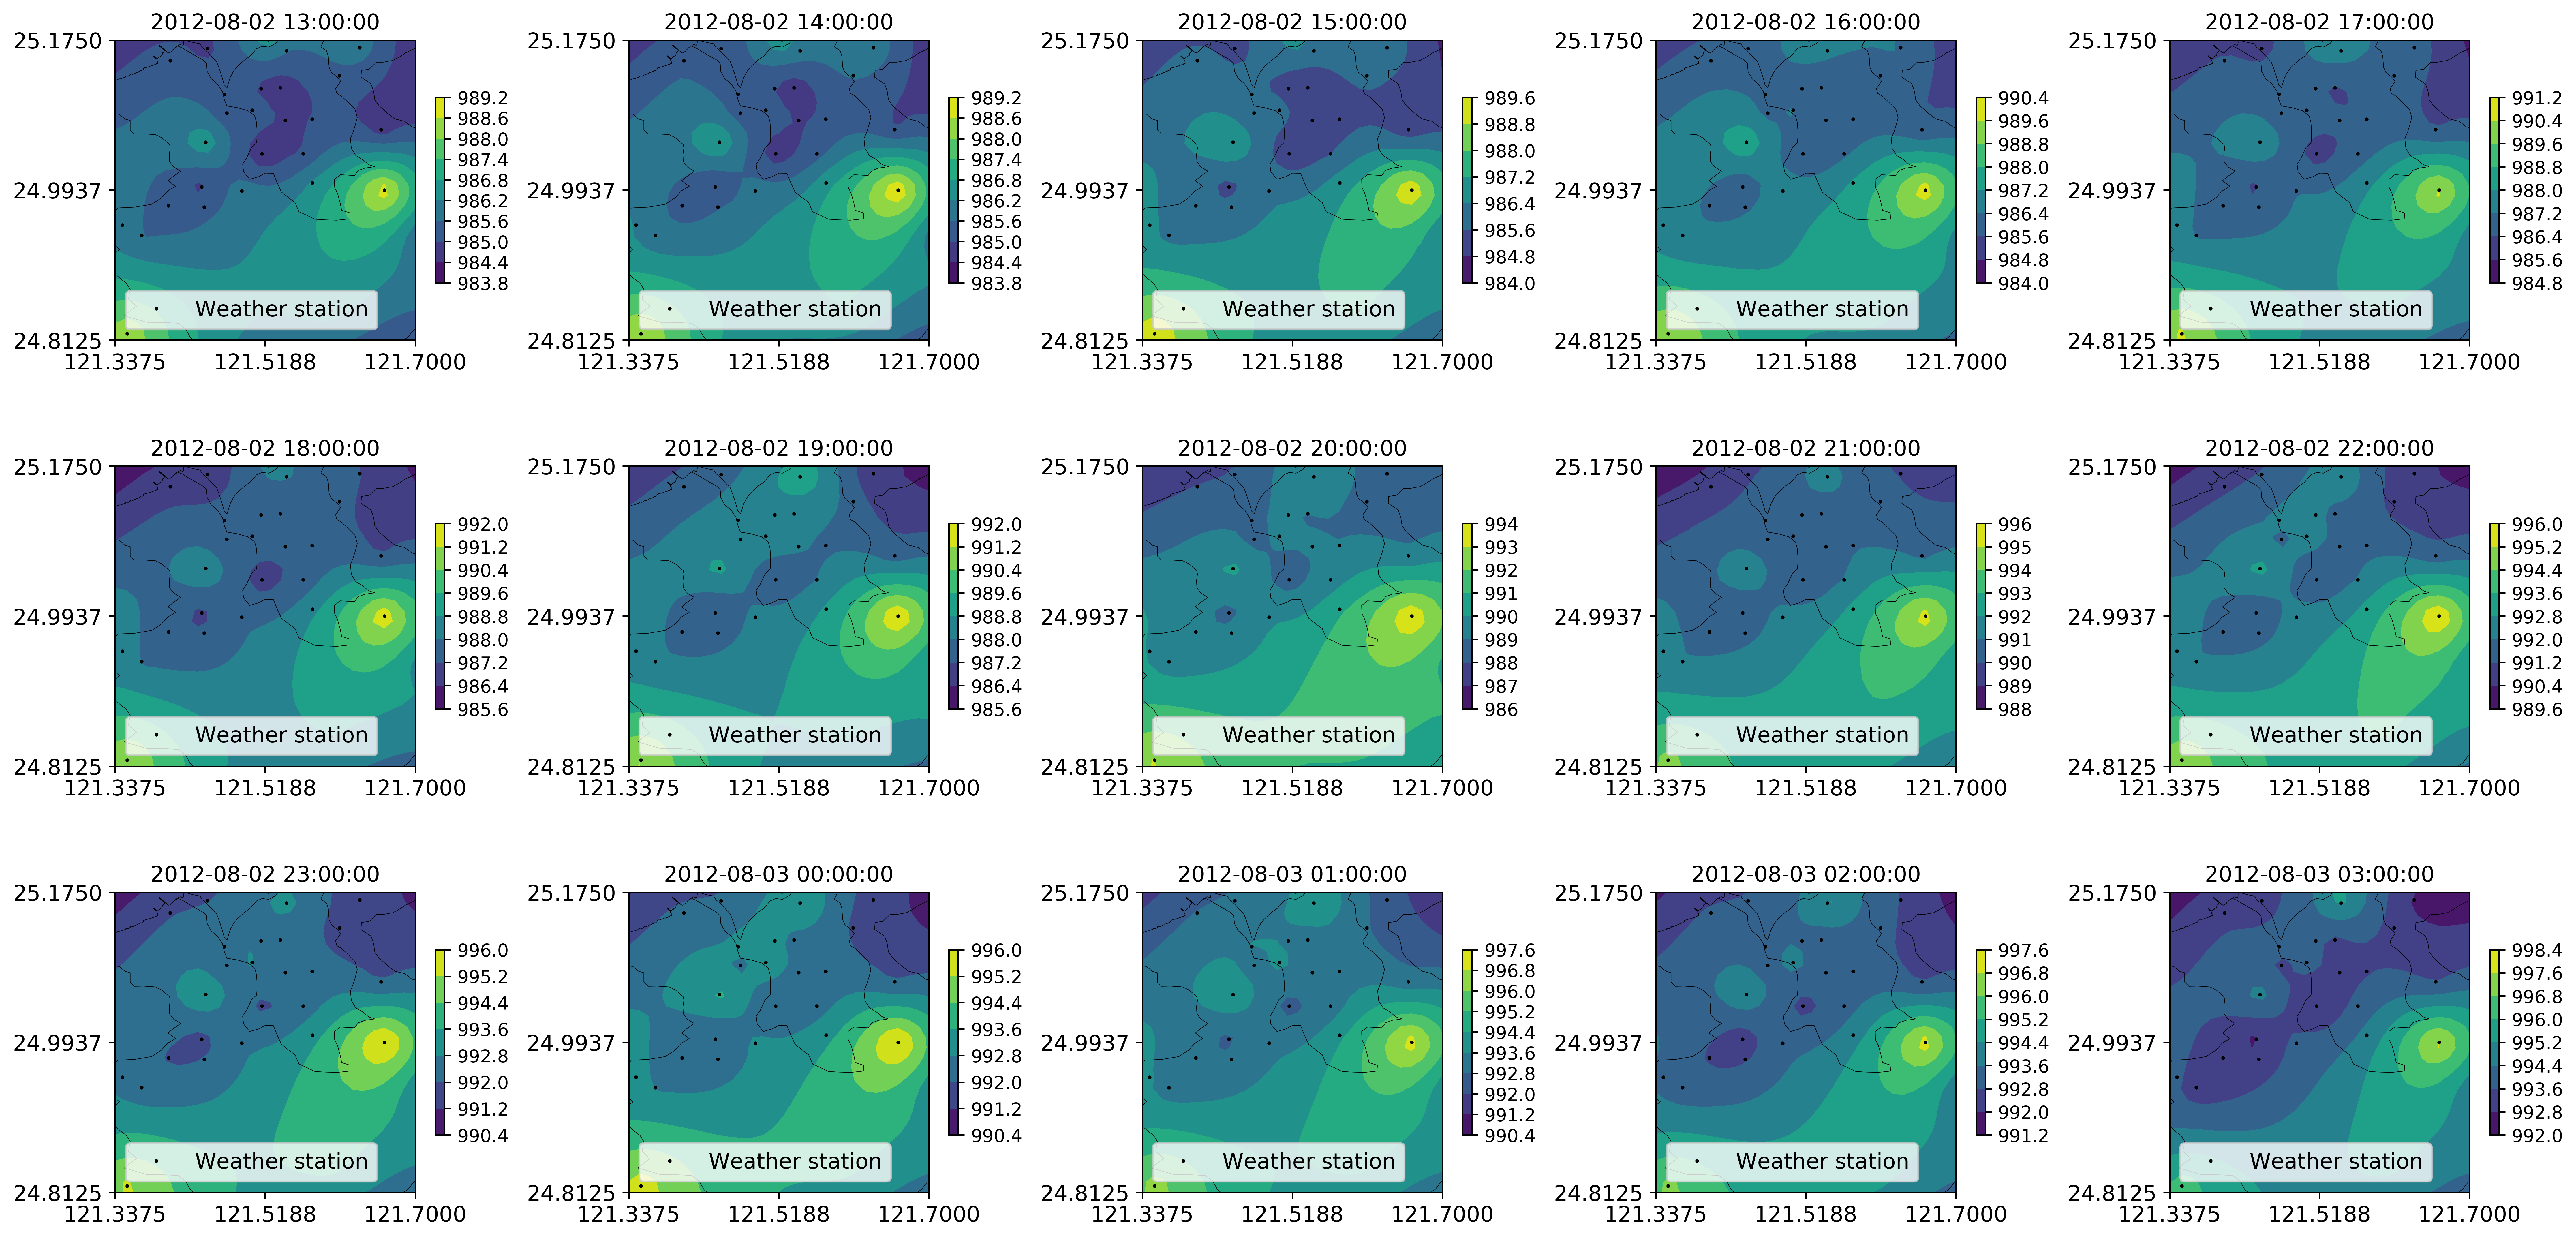

In [5]:
timestep = ty_list['Time of canceling'] - ty_list['Time of issuing']

X, Y = np.meshgrid(args.xaxis_list, args.yaxis_list)

Xi, Yi = X.flatten(), Y.flatten()
fontsize = 12
m = Basemap(projection='cyl', resolution='h', llcrnrlat=args.F_y[0], 
            urcrnrlat=args.F_y[1], llcrnrlon=args.F_x[0], urcrnrlon=args.F_x[1])

for idx, i in enumerate(timestep[:1]):
    timelines = [ty_list['Time of issuing'][idx]+dt.timedelta(hours=x) for x in range(i.days*24+i.seconds//3600)][40:55]
    fig, ax = plt.subplots(len(timelines)//5, 5, dpi=args.figure_dpi*3, figsize=(20,10))
    data_man = os.path.join(args.weather_raw_data_folder, str(ty_list.iloc[idx,2].year)+'.Data', str(ty_list.iloc[idx,2].year)+'_Station_hr_man', 
                            ty_list.iloc[idx,0]+'.txt')
    data_auto = os.path.join(args.weather_raw_data_folder, str(ty_list.iloc[idx,2].year)+'.Data', str(ty_list.iloc[idx,2].year)+'_Station_hr_auto', 
                             ty_list.iloc[idx,0]+'.txt')
    data = read_data(data_man, data_auto, sta_list)
    
    for idj, j in enumerate(timelines):
        dd = ax[idj//5][idj%5]
        x = data.loc[j,'lon'].values
        y = data.loc[j,'lat'].values
#         z = data.loc[j,'PS01'].values
        z = localP_2_seaP(p=data.loc[j, 'PS01'].values, h=data.loc[j, 'height'].values, t=data.loc[j, 'TX01'].values)
        sci_IDW = Rbf(x, y, z, function='linear')
        Zi = sci_IDW(Xi, Yi).reshape(args.I_shape[0], args.I_shape[1])
        if 1:
            _ = m.readshapefile(args.TW_map_file, name='Taiwan', linewidth=0.25, drawbounds=True, color='k', ax=dd)
            m.plot(x, y,'.', color='k', markersize=2, ax=dd, label='Weather station')
            cs = m.contourf(x=X, y=Y, data=Zi, ax=dd)
            cbar = fig.colorbar(cs, ax=dd, fraction=0.2, shrink=0.5)
            cbar.ax.tick_params(labelsize=10)
            
#             dd.set_xlabel(r'longtitude($^o$)', fontdict={'fontsize': fontsize})
#             dd.set_ylabel(r'latitude($^o$)', fontdict={'fontsize': fontsize})
            _ = dd.set_xticks(ticks = np.linspace(args.F_x[0], args.F_x[1], 5))
            _ = dd.set_yticks(ticks = np.linspace(args.F_y[0], args.F_y[1], 5))
            dd.tick_params('both', labelsize=fontsize)
            dd.locator_params(nbins=4)
            dd.legend(fontsize=fontsize)
            dd.set_title(j, fontsize=fontsize)
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.tight_layout()

#### PS01 測站氣壓(hPa)
#### TX01 氣溫(℃)
#### RH01 相對濕度(%)
#### WD01 平均風風速(m/s)
#### WD02 平均風風向(360 degree)
#### PP01 降水量(mm)

In [10]:
timestep = ty_list['Time of canceling'] - ty_list['Time of issuing']

X, Y = np.meshgrid(args.xaxis_list, args.yaxis_list)
Xf, Yf = X.flatten(), Y.flatten()

column = pd.Index(args.xaxis_list, name='lon')
index = pd.Index(args.yaxis_list, name='lat')
if not os.path.exists(args.weather_wrangled_data_folder):
    for idx, i in enumerate(timestep):
        print(ty_list.iloc[idx,1])
        timelines = [ty_list['Time of issuing'][idx]+dt.timedelta(hours=x) for x in range(i.days*24+i.seconds//3600+1)]
        data_man = os.path.join(args.weather_raw_data_folder, str(ty_list.iloc[idx,2].year)+'.Data', 
                                str(ty_list.iloc[idx,2].year)+'_Station_hr_man', ty_list.iloc[idx,0]+'.txt')
        data_auto = os.path.join(args.weather_raw_data_folder, str(ty_list.iloc[idx,2].year)+'.Data', 
                                 str(ty_list.iloc[idx,2].year)+'_Station_hr_auto', ty_list.iloc[idx,0]+'.txt')
        data = read_data(data_man, data_auto, sta_list)
        
        for j in range(len(timelines)-1):
            x1 = data.loc[timelines[j]].lon.to_numpy()
            y1 = data.loc[timelines[j]].lat.to_numpy()
            x2 = data.loc[timelines[j+1]].lon.to_numpy()
            y2 = data.loc[timelines[j+1]].lat.to_numpy()

            for k in data.columns[1:-3]:
                output_folder = os.path.join(args.weather_wrangled_data_folder, k)
                if not os.path.exists(output_folder):
                    print(output_folder)
                    createfolder(output_folder)

                z1 = data.loc[timelines[j], k].to_numpy()
                z2 = data.loc[timelines[j+1], k].to_numpy()
                if k == 'PS01':
                    z1 = localP_2_seaP(p=data.loc[timelines[j], k].to_numpy(), h=data.loc[timelines[j], 'height'].to_numpy(), 
                                       t=data.loc[timelines[j], 'TX01'].to_numpy())
                    z2 = localP_2_seaP(p=data.loc[timelines[j+1], k].to_numpy(), h=data.loc[timelines[j+1], 'height'].to_numpy(), 
                                       t=data.loc[timelines[j+1], 'TX01'].to_numpy())

                sci_IDW_1 = Rbf(x1, y1, z1, function='linear')
                Z1 = sci_IDW_1(Xf, Yf).reshape(args.I_shape[0], args.I_shape[1])
                Z1[Z1 < 0] = 0
                Z1 = pd.DataFrame(Z1, columns=column, index=index)

                sci_IDW_2 = Rbf(x2, y2, z2, function='linear')
                Z2 = sci_IDW_2(Xf, Yf).reshape(args.I_shape[0], args.I_shape[1])
                Z2[Z2 < 0] = 0
                Z2 = pd.DataFrame(Z2, columns=column, index=index)

                for i in range(7):
                    Z = Z1+(Z2-Z1)*i/5
                    output_path = os.path.join(output_folder, str(timelines[j].year)+'.'+ty_list.iloc[idx,0]+'.{:s}.pkl'.format(dt.datetime.strftime(timelines[j]+dt.timedelta(minutes=10*i), format='%Y%m%d%H%M')))
                    Z.to_pickle(output_path, compression=args.compression)

蘇拉
/home/utmostof9/ssd/01_ty_research/02_meteorological_data/01_wrangled_files/PS01
/home/utmostof9/ssd/01_ty_research/02_meteorological_data/01_wrangled_files/TX01
/home/utmostof9/ssd/01_ty_research/02_meteorological_data/01_wrangled_files/RH01
/home/utmostof9/ssd/01_ty_research/02_meteorological_data/01_wrangled_files/WD01
/home/utmostof9/ssd/01_ty_research/02_meteorological_data/01_wrangled_files/WD02
/home/utmostof9/ssd/01_ty_research/02_meteorological_data/01_wrangled_files/PP01
蘇力
潭美
康芮
天兔
菲特
麥德姆
昌鴻
蘇迪勒
杜鵑
馬勒卡
梅姬
瑪莉亞


## 求最大最小值

In [16]:
timestep = ty_list['Time of canceling'] - ty_list['Time of issuing']

X, Y = np.meshgrid(args.xaxis_list, args.yaxis_list)
Xf, Yf = X.flatten(), Y.flatten()

column = pd.Index(args.xaxis_list, name='lon')
index = pd.Index(args.yaxis_list, name='lat')

max_value = np.zeros(6)
min_value = np.ones(6)*10000


for idx, i in enumerate(timestep):
    print(ty_list.iloc[idx,2].year, ty_list.iloc[idx,1])
    timelines = [ty_list['Time of issuing'][idx]+dt.timedelta(hours=x) for x in range(i.days*24+i.seconds//3600+1)]
    data_man = os.path.join(args.weather_raw_data_folder, str(ty_list.iloc[idx,2].year)+'.Data', str(ty_list.iloc[idx,2].year)+'_Station_hr_man', ty_list.iloc[idx,0]+'.txt')
    data_auto = os.path.join(args.weather_raw_data_folder, str(ty_list.iloc[idx,2].year)+'.Data', str(ty_list.iloc[idx,2].year)+'_Station_hr_auto', ty_list.iloc[idx,0]+'.txt')
    data = read_data(data_man, data_auto, sta_list)
    # max
    data['PS01'] = localP_2_seaP(p=data['PS01'].to_numpy(), h=data['height'].to_numpy(), t=data['TX01'].to_numpy())
    
    max_tmp = data.iloc[:,1:-3].max().to_numpy()
    max_value[max_tmp > max_value] = max_tmp[max_tmp > max_value]
    
    # min
    min_tmp = data.iloc[:,1:-3].min().to_numpy()
    min_value[min_tmp < min_value] = min_tmp[min_tmp < min_value]
    
outputpath = os.path.join(args.weather_folder, 'overall.csv')
pd.DataFrame([max_value,min_value], index=pd.Index(['max','min'], name='Measures'), columns=pd.Index(data.columns[1:-3])).to_csv(outputpath)

2012 蘇拉
2013 蘇力
2013 潭美
2013 康芮
2013 天兔
2013 菲特
2014 麥德姆
2015 昌鴻
2015 蘇迪勒
2015 杜鵑
2016 馬勒卡
2016 梅姬
2018 瑪莉亞


In [14]:
pd.DataFrame([max_value,min_value], index=['max','min'], columns=data.columns[1:-3])

,PS01,TX01,RH01,WD01,WD02,PP01
max,1034.614,37.8,100.0,55.3,360.0,235.0
min,951.551,2.1,0.0,0.0,0.0,0.0


In [18]:

pd.DataFrame([max_value,min_value], index=pd.Index(['max','min'], name='Measures'), columns=pd.Index(data.columns[1:-3])).to_csv(outputpath)